# Application of DJUICE: Pine Island Glacier

In this tutorial, we will work on a real-world case: modeling the [Pine Island Glacier](https://en.wikipedia.org/wiki/Pine_Island_Glacier) in West Antarctica. We are going to simulate the ice velocity using the ice geometry measured from satellites.

## Set up the model

To simplify the model setup process, we will load the model from an [ISSM tutorial of Pine Island Glacier](https://issm.jpl.nasa.gov/documentation/tutorials/pig/).

Before solving the model, we should take some time to inspect the model by plotting the ice thickness, bed elevation, basal friction coefficients, and other relevant parameters. This helps ensure that the model has been loaded correctly.

**Note**: You might get warnings during this process because the ISSM model contains more fields than the DJUICE model currently supports. You can safely ignore these warnings for now.

In [1]:
using DJUICE

#Load model from a MATLAB ISSM model structure
using MAT
file = matopen(joinpath(@__DIR__, "..", "data","PIG_Control_drag_dJUICE.mat"))  
mat  = read(file, "md")
close(file)
md = model(mat, false)

┌ Warning: MATLAB bamggeom values are currently not supported
└ @ MAT.MAT_HDF5 /Users/eyhli/.julia/packages/MAT/K2D15/src/MAT_HDF5.jl:169
┌ Warning: MATLAB bamgmesh values are currently not supported
└ @ MAT.MAT_HDF5 /Users/eyhli/.julia/packages/MAT/K2D15/src/MAT_HDF5.jl:169
┌ Warning: MATLAB qmustatistics values are currently not supported
└ @ MAT.MAT_HDF5 /Users/eyhli/.julia/packages/MAT/K2D15/src/MAT_HDF5.jl:169
┌ Warning: MATLAB lovenumbers values are currently not supported
└ @ MAT.MAT_HDF5 /Users/eyhli/.julia/packages/MAT/K2D15/src/MAT_HDF5.jl:169
┌ Warning: MATLAB rotational values are currently not supported
└ @ MAT.MAT_HDF5 /Users/eyhli/.julia/packages/MAT/K2D15/src/MAT_HDF5.jl:169
┌ Warning: MATLAB solidearthsettings values are currently not supported
└ @ MAT.MAT_HDF5 /Users/eyhli/.julia/packages/MAT/K2D15/src/MAT_HDF5.jl:169


Model:


               mesh: DJUICE.Mesh2dTriangle      -- mesh properties
           geometry: DJUICE.Geometry            -- surface elevation, bedrock topography, ice thickness,...
               mask: DJUICE.Mask                -- defines grounded and floating regions
          materials: DJUICE.Materials           -- material properties
     initialization: DJUICE.Initialization      -- initial state
          constants: DJUICE.Constants           -- physical constants
           friction: DJUICE.BuddFriction        -- basal friction
      basalforcings: DJUICE.Basalforcings       -- basal forcings
                smb: DJUICE.SMBforcings         -- surface mass balance
       timestepping: DJUICE.Timestepping        -- time stepping for transient simulations
      stressbalance: DJUICE.Stressbalance       -- parameters stress balance simulations
      masstransport: DJUICE.Masstransport       -- parameters mass transport simulations
          transient: DJUICE.Transient           -- parame

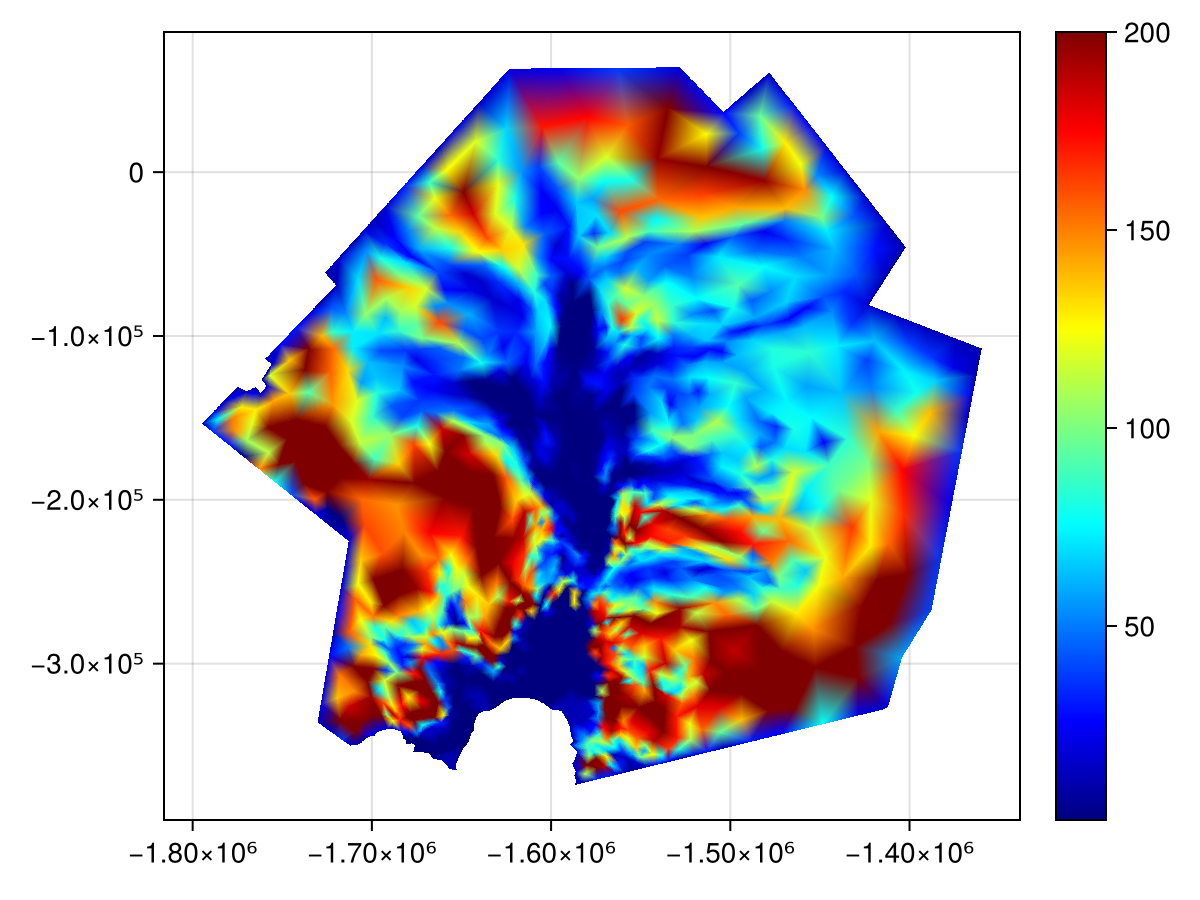

In [2]:
#show friction coefficient
using CairoMakie
plotmodel(md, md.friction.coefficient)

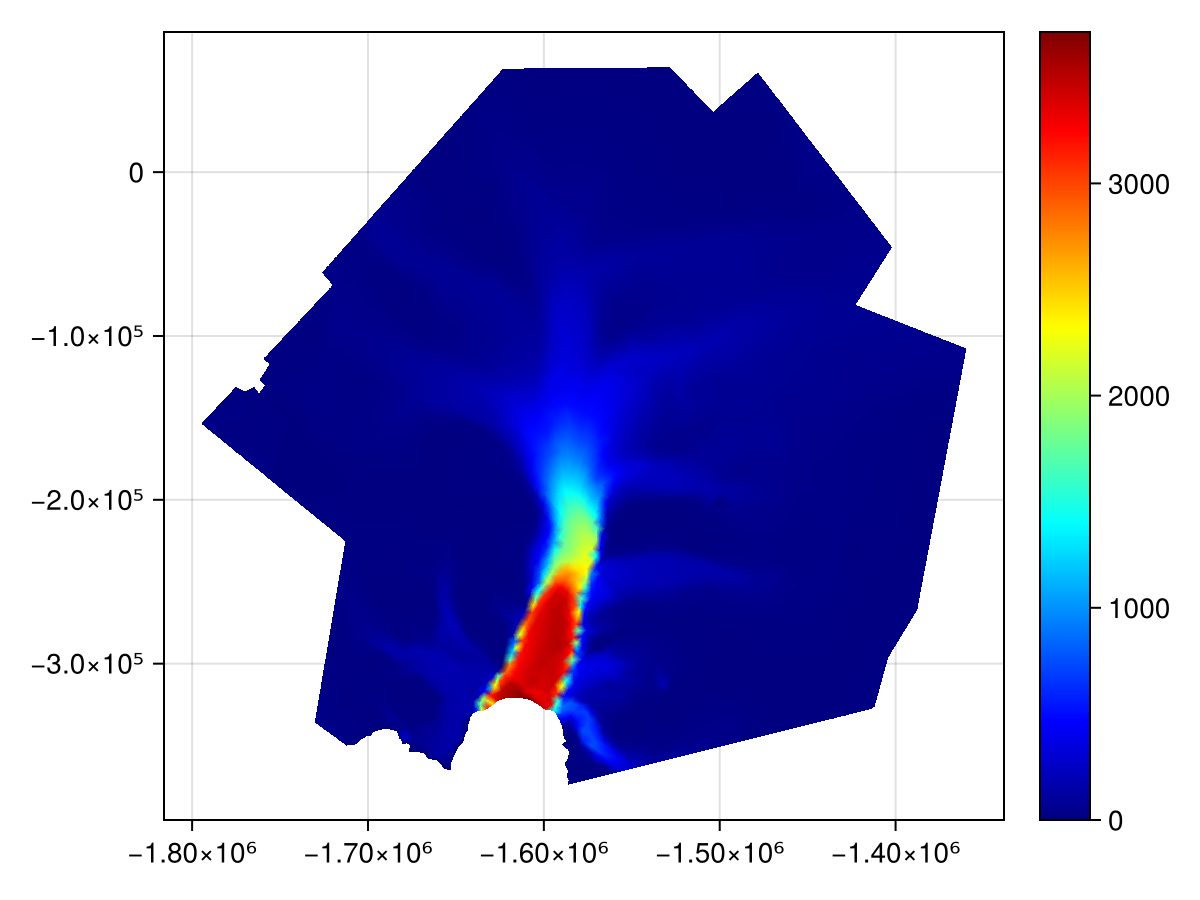

In [3]:
plotmodel(md, sqrt.(md.initialization.vx.^2+md.initialization.vy.^2))

## Solve the forward model

With all the geometries, boundary conditions, and ice masks properly set up in the model, we can solve the forward problem to get the simulated ice velocity.

Call the `solve` function to perform the stress balance computation:

In [4]:
#First, we need to turn off the "inversion" flag since we want to run a simple stress balance
md.inversion.iscontrol = false
solve(md, :Stressbalance);

   creating datasets for analysis DJUICE.StressbalanceAnalysis
      detecting active vertices
   computing stress balance
   Renumbering degrees of freedom
   Allocating matrices
   Assembling matrices
   Solving matrix system
   checking convergence
   mechanical equilibrium convergence criterion 63.273692523666256 > 1.0 %
   Convergence criterion: norm(du)/norm(u)      13.13946236236299 > 10.0 %
   Allocating matrices
   Assembling matrices
   Solving matrix system
   checking convergence
   mechanical equilibrium convergence criterion 8.258839046426875 > 1.0 %
   Convergence criterion: norm(du)/norm(u)      5.189870510619527 < 10.0 %
   Allocating matrices
   Assembling matrices
   Solving matrix system
   checking convergence
   mechanical equilibrium convergence criterion 3.0492377763040035 > 1.0 %
   Convergence criterion: norm(du)/norm(u)      3.4649469645216064 < 10.0 %
   Allocating matrices
   Assembling matrices
   Solving matrix system
   checking convergence
   mechanical

Plot the resulting ice velocity field to visualize the results of the forward model:

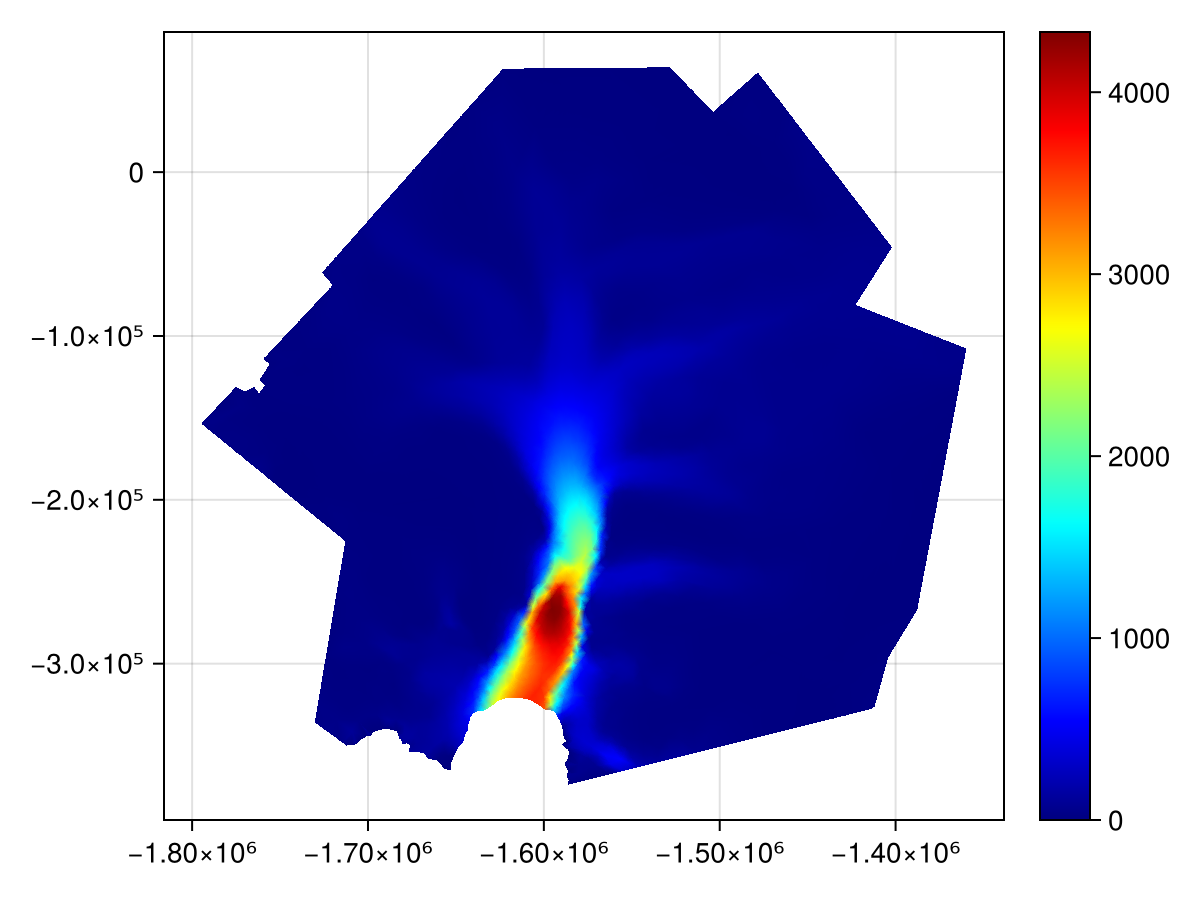

In [5]:
plotmodel(md, md.results["StressbalanceSolution"]["Vel"])

## Sensitivity analysis

By using `Enzyme`, we can perform sensitivity analysis on the DJUICE model. This allows us to understand how changes in input parameters affect the model outputs.

In this example, we use a pre-defined *cost function* `SurfaceAbsVelMisfitx` from `DJUICE/src/core/costfunctions.jl`, which compute the absolute velocity misfit between modeled and observed velocity. 

The cost function $J$ in DJUICE is defined as: 

$${\mathcal J} = \frac{1}{2}\int_{\Omega}(u-u_{obs})^2+(v-v_{obs})^2\,\text{d}\Omega$$

For this tutorial, we set $u_{obs}$ and $v_{obs}$ to 0, simplifying the cost function to:

$${\mathcal J} = \frac{1}{2}\int_{\Omega}(u^2+v^2)\,\text{d}\Omega$$

Here, ${\mathcal J}$ measures the velocity magnitudes of the ice flow. The gradient $\frac{\partial{J}}{\partial{C}}$ we compute is the sensitivity of the velocity to the basal friction coefficents $C$.

In [6]:
using Enzyme
Enzyme.API.typeWarning!(false)
Enzyme.Compiler.RunAttributor[] = false
		
md.inversion.iscontrol = 1
md.inversion.vx_obs = zeros(md.mesh.numberofvertices)
md.inversion.vy_obs = zeros(md.mesh.numberofvertices)
md.inversion.independent = md.friction.coefficient
md.inversion.independent_string = "FrictionCoefficient"
md.inversion.dependent_string = ["SurfaceAbsVelMisfit"]
	
md = solve(md, :Stressbalance);

   creating datasets for analysis DJUICE.StressbalanceAnalysis
      detecting active vertices
   computing stress balance
   Renumbering degrees of freedom
   Allocating matrices
   Assembling matrices
   Solving matrix system
   checking convergence
   mechanical equilibrium convergence criterion 63.273692523666256 > 1.0 %
   Convergence criterion: norm(du)/norm(u)      13.13946236236299 > 10.0 %
   Allocating matrices
   Assembling matrices
   Solving matrix system
   checking convergence
   mechanical equilibrium convergence criterion 8.258839046426875 > 1.0 %
   Convergence criterion: norm(du)/norm(u)      5.189870510619527 < 10.0 %
   Allocating matrices
   Assembling matrices
   Solving matrix system
   checking convergence
   mechanical equilibrium convergence criterion 3.0492377763040035 > 1.0 %
   Convergence criterion: norm(du)/norm(u)      3.4649469645216064 < 10.0 %
   Allocating matrices
   Assembling matrices
   Solving matrix system
   checking convergence
   mechanical

After differentiating `DJUICE` by `Enzyme`, we can visualize the gradient and the friction coefficients:

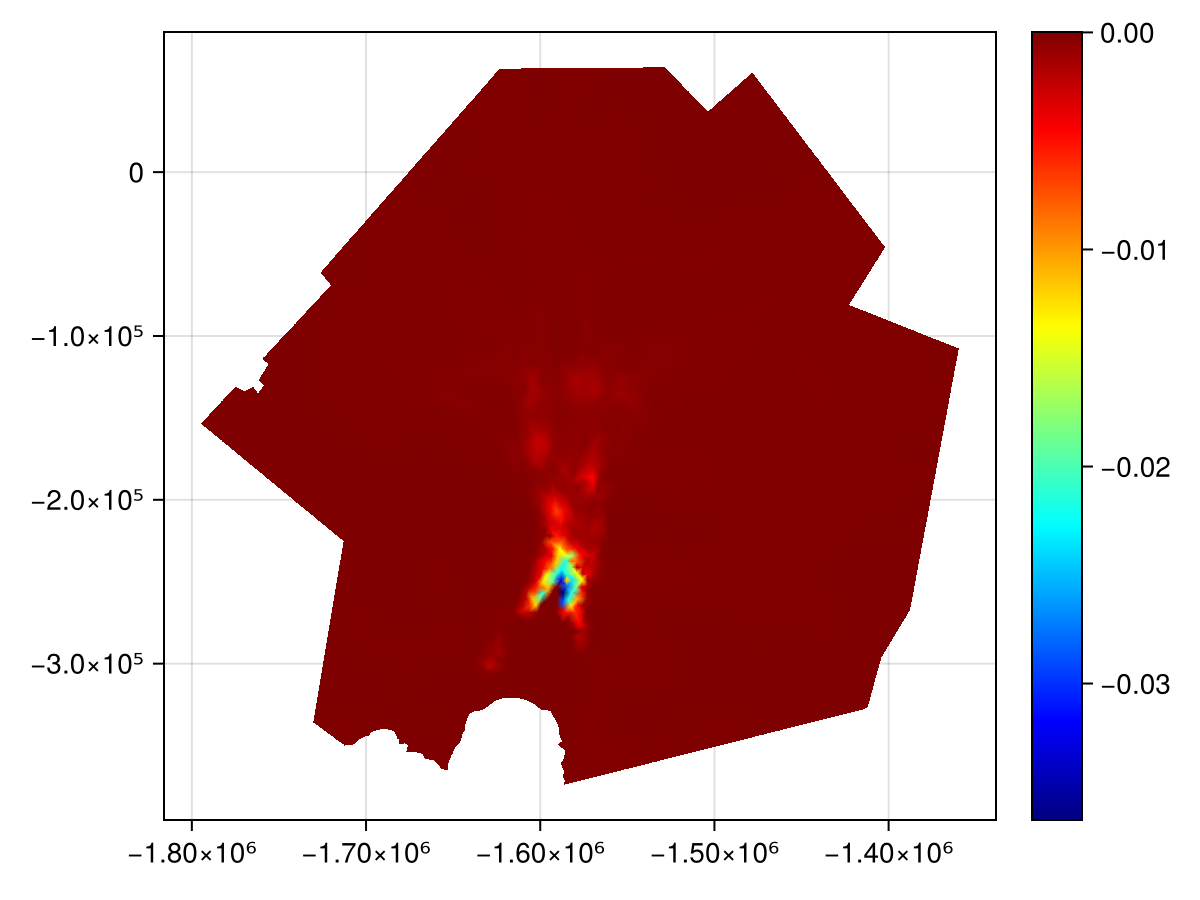

In [7]:
g = md.results["StressbalanceSolution"]["Gradient"]
plotmodel(md, g)

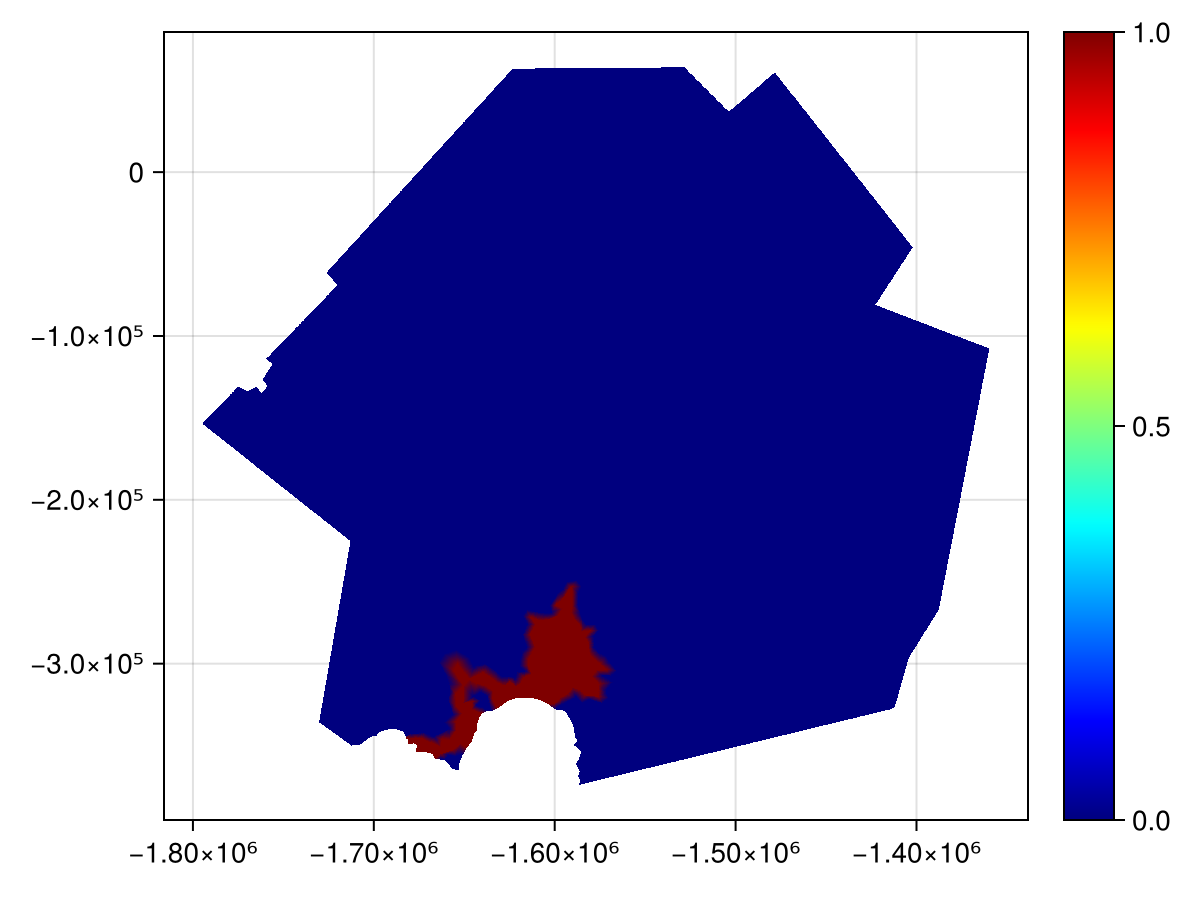

In [21]:
# Plot the masked gradient
plotmodel(md, Float64.(md.geometry.bed .!= md.geometry.base))

## Extra task
Ideally, we can use `Enzyme` to differentiate the cost function $J$ with respect to any variable in `DJUICE`. One example is to change the `independent` and `independent_string` to the ice `rheology_B`. 

```julia
md.inversion.independent = md.materials.rheology_B
md.inversion.independent_string = "MaterialsRheologyB"
```

Use the instructions and example code above as a guide to write your own code. Compute the sensitivity and analyze the results. 